In [19]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.__version__

'1.12.1+cu102'

# PyTorch workflow
<img src="img/01_a_pytorch_workflow.png" width="1100"/>

# 1. Data Preparing
In machine learning data can be almost anything you can imagine

Machine learning is a game of two parts:
1. Turn you data into numbers
2. Pick or build a model to learn the representation as best as possible

In [2]:
# now we create our data (it will be simple linear regression problem)

weight = 0.73221
bias = 0.36
start = 0
end = 3
step = 0.05

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias
print('Shape of X tensor is {} and y is {}'.format(X.shape, y.shape))

X[:5], y[:5]

Shape of X tensor is torch.Size([60, 1]) and y is torch.Size([60, 1])


(tensor([[0.0000],
         [0.0500],
         [0.1000],
         [0.1500],
         [0.2000]]),
 tensor([[0.3600],
         [0.3966],
         [0.4332],
         [0.4698],
         [0.5064]]))

We want to learn the relationship between `X` and `y`

In [3]:
train_split = int(0.8 * len(X))  ## 80% of our data will be used for training

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print('{} objects will be used for training and {} for testing'.format(len(X_train), len(X_test)))

48 objects will be used for training and 12 for testing


In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(17, 7))
    plt.scatter(train_data, train_labels, c='b', s=11, label='train')
    plt.scatter(test_data, test_labels, c='g', s=11, label='test')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', marker='*', s=15, label='predictions')
    plt.legend(prop={'size':12})

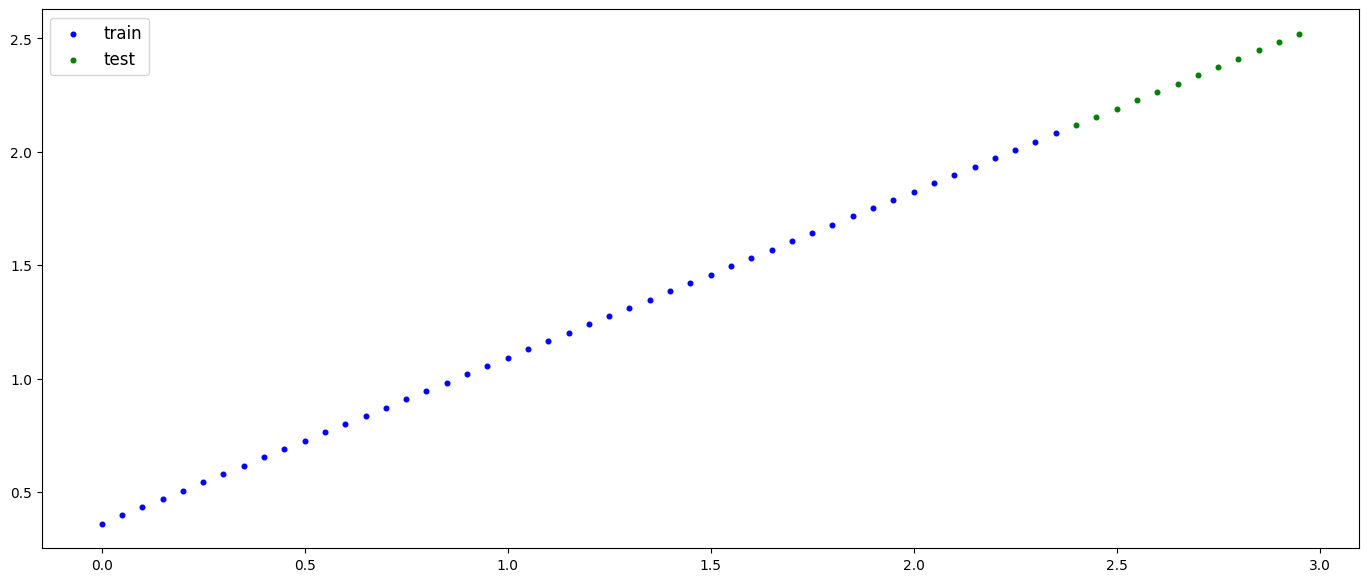

In [5]:
plot_predictions()

# 2. Build model

In [6]:
class SimpleLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(size=(1,),
                                              dtype=torch.float32,
                                              requires_grad=True))
        self.bias = nn.Parameter(torch.rand(size=(1,),
                                            dtype=torch.float32,
                                            requires_grad=True))
    def forward(self, input_object):
        # all subclasses of nn.Module require this method
        # to define the computation that will take place
        # on the data passed to model
        return self.weight * input_object + self.bias

PyTorch use 4 essential modules for any kind of neural network:
* `torch.nn` - all blocks for computational graphs
* `torch.optim` - various optimization algorithms (change model parameters stored in `nn.Parameter`)
* `torch.utils.data.Dataset` -
* `torch.utils.data.Dataloader` -

In [7]:
model_0 = SimpleLinearModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [8]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.8823])), ('bias', tensor([0.9150]))])

we can see predictive power of our model by using *inference mode*. It turns off a bunch of things (gradient tracking, dropout, ...) to make **forwrad-passes** faster and safely

In [9]:
tmp_loss = nn.L1Loss()
with torch.inference_mode():
    y_predicted = model_0(X_test)
    print('MAE is', tmp_loss(y_predicted, y_test).item())

# it is the same as torch.no_grad(), but new version ^-^

MAE is 0.9564126133918762


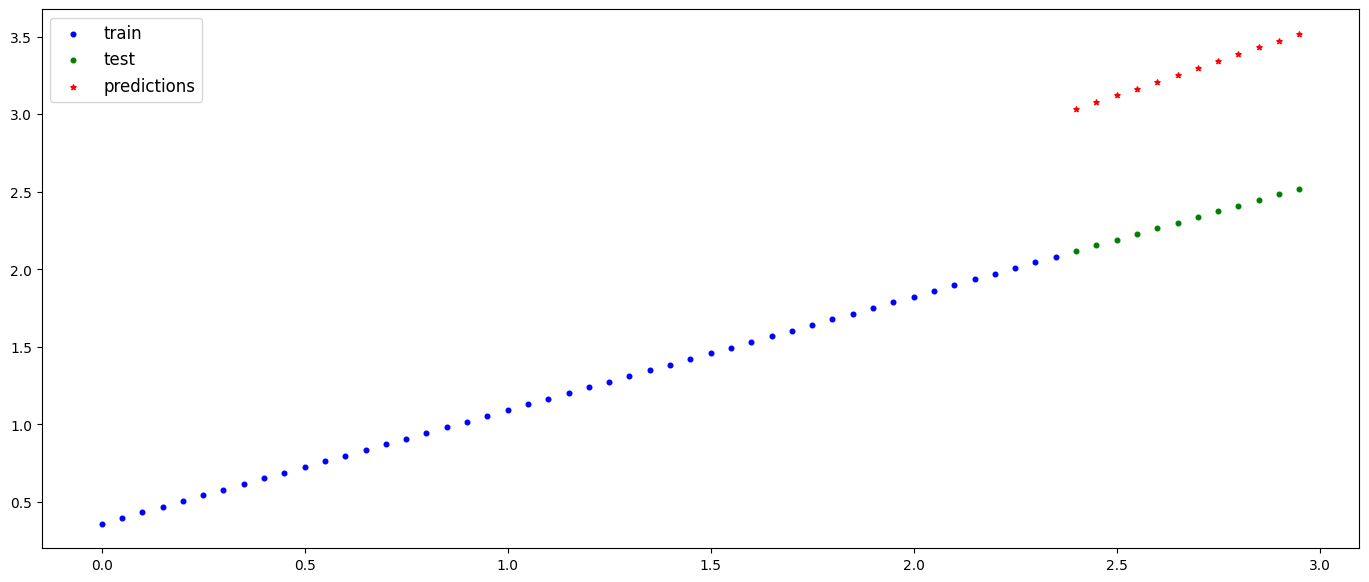

In [10]:
plot_predictions(predictions=y_predicted)

# 3. Train model
It is fun to write code and see if the model can try and figure them out itself

In [21]:
# create loss and optimizer

# loss measures how wrong your models predictions
loss_fn = nn.L1Loss()

# optimizer tells model how to update parameters to make it better
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

**Optimizer** and **loss function** depend on what kind of problem you're working on.

`lr` - **Learning rate** is the hyperparameter (it is set by engineer). Common values are `0.01`, `0.001`, `0.0001`, but these can also be adjusted over time (with help of **lr scheduling**)


*loop* because we want our model to look at each sample in dataset

**Steps (training loop):**
1) forward pass
2) calculate the loss
3) zero gradients
4) backpropagation
5) optimizer update model parameters

In [22]:
def train_loop(data=X_train,
               labels=y_train,
               model=model_0,
               optim=optimizer,
               loss=loss_fn):
    # train is default state of a model
    model.train()

    # forward pass
    y_pred = model(data)

    # calculate the loss
    loss_value = loss(y_pred, labels)

    # zero gradients
    optim.zero_grad()

    # backpropagation
    loss_value.backward()

    # optimizer update models parameters
    optim.step()

    return loss_value.detach().numpy()

**Steps (testing loop):**
1) forward pass
2) calculate the loss
3) evaluate model using metric

In [23]:
def test_loop(data=X_test,
              labels=y_test,
              model=model_0,
              loss=loss_fn,
              metric=None):
    model.eval()
    with torch.inference_mode():
        # forward pass
        y_pred = model(data)

        # calculate the loss
        loss_value = loss(y_pred, labels)

        print(f'loss value on the test - {loss_value.detach().numpy()}')
        # metric evaluation
        if metric is not None:
            m = metric(labels, y_pred)
            print(f'metric on the test - {m}')
        return loss_value.detach().numpy()

In [24]:
epochs = 15
loss_train = []
loss_test = []
for e in range(1, epochs+1):
    print(f'Epoch {e}/{epochs}')
    loss_train.append(train_loop())
    loss_test.append(test_loop())

Epoch 1/15
loss value on the test - 0.3119417726993561
Epoch 2/15
loss value on the test - 0.27522513270378113
Epoch 3/15
loss value on the test - 0.23857592046260834
Epoch 4/15
loss value on the test - 0.20203852653503418
Epoch 5/15
loss value on the test - 0.16573657095432281
Epoch 6/15
loss value on the test - 0.12982232868671417
Epoch 7/15
loss value on the test - 0.09475747495889664
Epoch 8/15
loss value on the test - 0.06119493767619133
Epoch 9/15
loss value on the test - 0.030664443969726562
Epoch 10/15
loss value on the test - 0.007399598602205515
Epoch 11/15
loss value on the test - 0.006469309329986572
Epoch 12/15
loss value on the test - 0.010668794624507427
Epoch 13/15
loss value on the test - 0.00867037009447813
Epoch 14/15
loss value on the test - 0.0043328008614480495
Epoch 15/15
loss value on the test - 0.010403215885162354


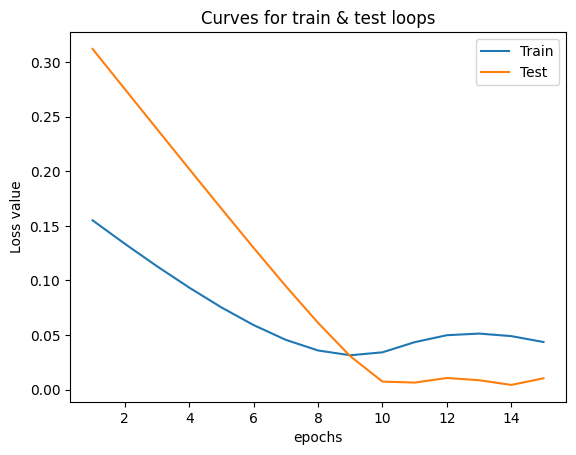

In [25]:
plt.plot(np.arange(1, epochs+1), loss_train, label='Train')
plt.plot(np.arange(1, epochs+1), loss_test, label='Test')
plt.title('Curves for train & test loops')
plt.xlabel('epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

In [26]:
print(f'the model parameters after learning: {model_0.state_dict()}')
print(f'original parameters: weight = {weight} and bias = {bias}')

the model parameters after learning: OrderedDict([('weight', tensor([0.7015])), ('bias', tensor([0.4318]))])
original parameters: weight = 0.73221 and bias = 0.36


# 4. Making predictions with a trained model (inference)